<center> <font size='6' font-weight='bold'> Model Part </font> </center>  
<center> <i> Projet Navee</i> </center>
<center> <i> Tony WU </i> </center>  
  
  
<img src=ressources/image_couverture.jpg>

# Modules

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
import io

# Tensorflow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Hyperparameters
from tensorboard.plugins.hparams import api as hp

# Interactive
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
from IPython.display import display

ModuleNotFoundError: No module named 'tensorboard.plugins.hparams'

# Creation of the Neural Network

In [2]:
print(tf.__version__)

1.13.1


Should be `2.1.0` or higher.

# Tensorboard callback configuration

**Important :**
Run the following cell in order to load tensorboard seemlessly in the notebook!

In [47]:
%load_ext tensorboard

The tensorboard module is not an IPython extension.


We'll store all the logs in a directory named `logs`.  
In this folder, we'll have subfolders, each named according to what kind of data it stores. For instance, the line below stores scalars values (such as accuracy and loss with respect to epochs).

In [3]:
logdir_scalars = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir_scalars)

Run `tensorboard --logdir logs` in Terminal to launch Tensorboard.

# Loading dataset

The following lines make sure the given directory exists.

In [4]:
data_path = '101_ObjectCategories'

assert os.path.isdir(data_path), 'Dataset not found 👎🏻'
print ('Dataset found 🤙🏻')

Dataset found 🤙🏻


## Some useful functions

In [5]:
def get_data(data_path, img_size, batch_size, validation_split = 0.2, **kwargs):
    '''Given a directory containing all the images stored in folders named with the corresponding label,
    this function returns two data generators object.
    
    Inputs:
        - data_path = string
        - img_size = 2-tuple of the images' dimensions
        - batch_size = size of the batch (please input power of 2 for more efficiency)
        - validation_split = float between 0 and 1 that gives the percentage allocated to the validation set
        - **kwargs = optional dictionary which contains arguments for data augmentation
        
    Outputs:
        - ImageDataGenerator object
    '''
    
    datagen = ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=preprocess_input,
                                 validation_split=validation_split,
                                 **kwargs)
    
    train_generator = datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset = 'training')

    validation_generator = datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset = 'validation')
    
    return train_generator, validation_generator

In [6]:
def show_img(data_gen, batch_idx, idx):
    ''''Display the prompted image with MatPlotLib.
    
    Inputs:
        - data_gen = a generator returned by get_data for instance
        - imgbatch_idx = the index of the batch
        - idx = the index of the image inside the selected batch
        
    Outputs:
        - an ImageDataGenerator object
    '''
    
    
    plt.imshow(data_gen[batch_idx][0][idx])
    return 

In [7]:
def show_label(data_gen, batch_idx, idx):
    ''''Returns the label of the prompted image.
    
    Inputs:
        - data_gen = a generator returned by get_data for instance
        - imgbatch_idx = the index of the batch
        - idx = the index of the image inside the selected batch
        
    Outputs:
        - a string
    '''
    
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    
    return labels[np.argmax(data_gen[batch_idx][1][idx])]

In [34]:
def get_batch_size(image_generator):
    '''
    Returns the number of batches of a set contained in an ImageGenerator object.
    
    Input:
        - image_generator = ImageGenerator object
    Output:
        - len(train_generator) = number of batches
    '''
    return len(train_generator)

## Some examples

In [8]:
img_size = (120, 120)
batch_size = 32

In [9]:
train_generator, validation_generator = get_data(data_path, img_size, batch_size, validation_split = 0.2)

Found 7356 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.


In [35]:
nb_batches = get_batch_size(train_generator)
print(f'nb_batches = {nb_batches}')

nb_batches = 230


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'Motorbikes'

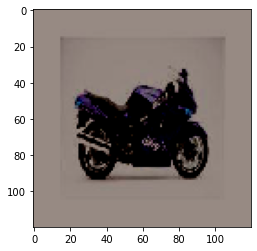

In [11]:
batch_idx = np.random.randint(0, nb_batches)
idx = np.random.randint(0, len(train_generator[0][0]))

show_img(train_generator, batch_idx, idx)
show_label(train_generator, batch_idx, idx)

In [12]:
def explore_train_generator(data_gen_idx, batch_idx, idx):
    data_gen = train_generator if data_gen_idx == 0 else validation_generator
    show_label(data_gen, batch_idx, idx)
    show_img(data_gen, batch_idx, idx)
    return

data_gen_idx_widget = widgets.Dropdown(
    options=[('train_generator', 0), ('validation_generator', 1)],
    value=1,
    description='data_gen',
)

batch_idx_widget = IntSlider(min=0, max=10, step=1, continuous_update=False)
idx_widget = IntSlider(min=0, max=100, step=1, continuous_update=False)

def update_widgets(*args):
    if data_gen_idx_widget.value == 0:
        batch_idx_widget.max = len(train_generator)
        idx_widget.max = len(train_generator[0][0]) - 1
    else:
        batch_idx_widget.max = len(validation_generator)
        idx_widget.max = len(validation_generator[0][0]) - 1
batch_idx_widget.observe(update_widgets, 'value')
idx_widget.observe(update_widgets, 'value')

interact(explore_train_generator,
         data_gen_idx = data_gen_idx_widget,
         batch_idx=batch_idx_widget,
         idx=idx_widget);

interactive(children=(Dropdown(description='data_gen', index=1, options=(('train_generator', 0), ('validation_…

# Creating the model

## Some utilities first

We'll start from Matheus's empirical model which is the following:
```python
model = Sequential()
model.add(ResNet50(include_top = False,weights = 'imagenet'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dense(102,activation='softmax'))
```

However, we choose instead to give to `generate_model` a `hparams` argument so much so that it'll be much easier to buid the hyperparameter tuning function and we won't have to hardcode those into the `generate_model` function.  
Moreover, all the following functions automatically log their data in *Tensorboard*.

In [28]:
def generate_model(hparams):
    '''
    A function that generates the model based on the hyperparameters that are given.
    The model is not yet compiled, neither with the weights

    Inputs:
        - hparams: a dictionnary containning, at least, the following hyperparameters (in parenthesis is the hyperparameter key)
          - 'HP_DROPOUT': value for dropout'
          - 'HP_NUM_UNITS_RELU': number of units in the second to last (Dense) layer
          - 'HP_NB_FROZEN_LAYERS': gives how many layers we'd like to freeze
          - 'HP_LOSS': choice of the loss function

    Output:
            - a model compiled but not trained, with the given hyperparamaters

    '''
    
    # Building the model step by step
    model = Sequential()
    model.add(ResNet50(include_top = False, weights = 'imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(hparams['HP_DROPOUT']))
    model.add(Dense(units=hparams['HP_NUM_UNITS_RELU'], activation='relu'))
    model.add(Dense(102,activation='softmax'))
    
    model.compile(optimizer='adam', loss=hparams['HP_LOSS'], metrics=['accuracy'])
    
    # Freezing some layers depending of the corresponding hyperparameter  
    for i in range(hparams['HP_NB_FROZEN_LAYERS']):
            model.layers[0].layers[-(i+1)].trainable = False
    
    return model

In [44]:
def fit_model(model, train_generator, epochs):
    '''
    This function trains the model given as an input as well as logging some useful data in Tensorboard.
    SIDE-EFFECT as model is modified on place.
    
    Inputs:
        - model: a compiled but not trained model
        - train_generator: an ImageGenerator objects
        - epochs: number of epochs

    Output:
      - a History object
    '''
    
    # Tensorflow configuration
    logdir = 'logs'
    
    # Creating callbacks
    tensorboard_callbacks = keras.callbacks.TensorBoard(log_dir=os.path.join(logdir, 'scalars'))

    # Fitting the model
    history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=get_batch_size(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps= get_batch_size(validation_generator),
        verbose=1,
        shuffle=True,
        callbacks=[tensorboard_callbacks]
    )

    return history

In [40]:
def load_weights(model, weights_filepath):
    '''
    A function that loads weights to the model.
    The function raise an exception if the file is not a .h5

    Inputs:
      - model: a generated keras model
      - weights_filepath: the filepath to weights data, must be a .h5 file

    Output:
      - None
    '''
    
    assert os.isfile(weights_filepath), 'Weights file not found 👎🏻'
    print('Weights file found 🤙🏻')
    
    model.load_weights('weigths_filepath')
    return

## Example with Matheus's empirical results

In [41]:
hparams = {
    'HP_DROPOUT': 0.3,
    'HP_NUM_UNITS_RELU': 512,
    'HP_NB_FROZEN_LAYERS': 1,
    'HP_LOSS': 'categorical_crossentropy'
}

In [42]:
model = generate_model(hparams)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 102)               52326     
Total params: 24,689,126
Trainable params: 24,636,006
Non-trainable params: 53,120
_________________________________________________________________


In [46]:
epochs=10
fit_model(model, train_generator, epochs)

Epoch 1/10


KeyboardInterrupt: 

The following line gives the 

The following line gives the accuracy on the validation set, which is the quantity we care about:

In [ ]:
model.evaluate_generator(validation_generator)

# Hyperparameters tuning

## Utilities

Below is an alternative version of `fit_model` that has to be used with the `tune_hparams` function (defined later).

In [ ]:
def fit_model_hparams(model, hparams train_generator, epochs):
    '''
    This function trains the model given as an input.
    SIDE-EFFECT as model is modified on place.
    
    Inputs:
        - model: a compiled but not trained model
        - hparams: a dictionnary containning, at least, the following hyperparameters (in parenthesis is the hyperparameter key)
          - 'HP_DROPOUT': value for dropout'
          - 'HP_NUM_UNITS_RELU': number of units in the second to last (Dense) layer
          - 'HP_NB_FROZEN_LAYERS': gives how many layers we'd like to freeze
          - 'HP_LOSS': choice of the loss function
      - train_generator: an ImageGenerator object
      - epochs: number of epochs

    Output:
      - a History object
    '''
    
    # Tensorflow configuration
    logdir = 'logs'
    
    # Creating callbacks
    tensorboard_callbacks = keras.callbacks.TensorBoard(log_dir=os.path.join(logdir, 'scalars'))
    tensorboard_callbacks_hp = hp.KerasCallback(log_dir=os.path.join(logdir, 'hyperparameters'), hparams)

    # Fitting the model
    history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=get_nb_batch(train_generator),
        epochs=v,
        validation_data=validation_generator,
        validation_steps= get_nb_batch(validation_generator),
        verbose=1,
        shuffle=True,
        callbacks=[tensorboard_callbacks, tensorboard_callbacks_hp]
    )

    return history

In [ ]:
def fits_and_log_instance_hparams(model, hparams, train_generator, validation_generator, epochs):
    '''
    For each call, fits the model, logs an hparams summary with the hyperparameters and
    final accuracy.
    
    - Inputs:
        - model: compiled but not trained model
        - hparams: Dictionary containing all the hyperparameters
        - train_generator: ImageGenerator object
        - validation_generator: ImageGenerator object
        - epochs: number of epochs
    
    - Output:
        - None
    '''
    
    logdir_hparams = os.path.join('logs', 'hyperparameters')
    
    with tf.summary.create_file_writer(logdir_hparams).as_default():
        hp.hparams(hparams)  # record the values used in this run
        history = fit_model_hparams(model, hparams, train_generator, validation_generator, epochs)
        accuracy = history.history['accuracy']
        
        # Saving results
        tf.summary.scalar('accuracy', accuracy, step=1)
    return

In [ ]:
def tune_hparams(HPARAMS, train_generator, validation_generator, epochs):
    '''
    - Inputs:
        - HPARAMS: Dictionary with the following keys:
            - 'dropout'
            - 'num_units_relu'
            - 'nb_frozen_layers'
            - 'loss'
    
    - Outputs:
        None
    '''
    
    # Keeping the number of the current iteration
    session_num = 0
    
    for dropout in tf.linspace(HPARAMS['dropout'].domain.min_value, HP_DROPOUT.domain.max_value, 4):
        for num_units_relu in HPARAMS['num_units_relu'].domain.values:
            for nb_frozen_layers in HPARAMS['nb_frozen_layers'].domain.values:
                for loss in HPARAMS['loss'].domain.values:
                    
                    # Setting run_name
                    run_name = f"run-{session_num}"
                    
                    print(f'--- Starting trial: {run_name}\n')                   
                    
                    # Dictionary that will be passed to the hparams_config function to save the
                    # current config in Tensorboard.
                    current_hparams = {
                        HPARAMS['dropout'].name: float("%.2f"%float(dropout_rate)),
                        # NB: float("%.2f"%float(dropout_rate)) limits the number of decimals to 2
                        HPARAMS['nb_frozen_layers'].name: nb_frozen_layers
                        HPARAMS['num_units_relu'].name: num_units_relu,
                        HPARAMS['loss'].name: loss
                    }
                    
                    print(f'Current hparams:\n{current_hparams}\n')
                    
                    # Creating and compiling model
                    model = generate_model(current_hparams)
                    
                    # Saving data in Tensorboard
                    with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
                        hp.hparams_config(
                          hparams=current_hparams,
                          metrics=[hp.Metric('accuracy', display_name='Accuracy')],
                        )
                    
                    fits_and_log_instance_hparams(model, current_hparams, train_generator, validation_generator, epochs)
                    print('\n\n\n-------------------------------------------------------------\n\n')
                    
                    session_num += 1s

## Example

In [17]:
HPARAMS = {
    'HP_DROPOUT': hp.HParam('dropout', hp.RealInterval(0.1, 0.4)),
    'HP_NUM_UNITS_RELU': hp.HParam('num_units_relu', hp.Discrete([256, 512, 1024])),
    'HP_NB_FROZEN_LAYERS': hp.HParam('nb_frozen_layers', hp.Discrete(list(range(0,5)))),
    'HP_LOSS': hp.HParam('loss', hp.Discrete(['categorical_crossentropy']))
    }

NameError: name 'hp' is not defined